# ------------------- Charger les tables nécessaires -------------------

In [2]:
import os, pandas as pd
from sqlalchemy import create_engine

PGURL  = os.getenv("SUPABASE_DB_URL")
engine = create_engine(PGURL)

# calendar : on ne garde que listing_id, date, available
calendar = pd.read_sql(
    "SELECT listing_id, date, available::int AS avail_int FROM calendar",
    engine
)

# listings : pour récupérer le quartier
listings = pd.read_sql(
    "SELECT id, neighbourhood FROM listings",
    engine
)

# ------------------- Calcul du taux d’occupation par logement -------------------

In [3]:
# 1 = disponible, 0 = occupé
occ_listing = (1 - calendar.groupby("listing_id")["avail_int"].mean()).reset_index()
occ_listing.rename(columns={"avail_int": "occupancy_pct"}, inplace=True)

# ------------------- Agrégation par quartier -------------------

In [4]:
# merge pour obtenir le quartier
occ_listing = occ_listing.merge(listings, left_on="listing_id", right_on="id", how="left")

occ_neigh = (occ_listing.groupby("neighbourhood")["occupancy_pct"]
             .mean()
             .sort_values(ascending=False)
             .to_frame("avg_occupancy_pct"))

occ_neigh.head()

,avg_occupancy_pct
neighbourhood,
Kirkland,0.779949
Dorval,0.553882
Rivière-des-Prairies-Pointe-aux-Trembles,0.548163
Beaconsfield,0.526603
Anjou,0.503462


# ------------------- Visualiser les 10 quartiers les plus occupés -------------------

<Figure size 700x400 with 0 Axes>

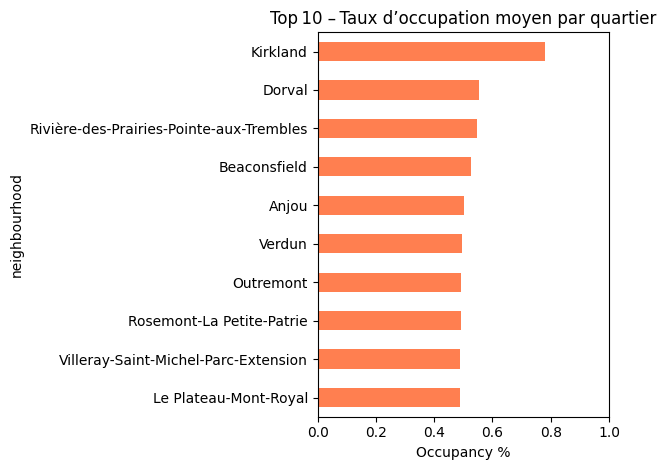

In [5]:
import matplotlib.pyplot as plt

top10_occ = occ_neigh.head(10)

plt.figure(figsize=(7,4))
top10_occ[::-1].plot(kind="barh", legend=False, color="coral")
plt.title("Top 10 – Taux d’occupation moyen par quartier")
plt.xlabel("Occupancy %")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# ------------------- Export CSV pour la carte ou l’API -------------------

In [6]:
occ_neigh.reset_index().to_csv("outputs/occupancy_pct_by_neigh.csv", index=False)

# ------------------- Observations Markdown -------------------

In [ ]:
from IPython.display import Markdown

quartier_occ = top10_occ.index[0]
pct_occ      = top10_occ.iloc[0,0] * 100

quartier_low = occ_neigh.tail(1).index[0]
pct_low      = occ_neigh.tail(1).iloc[0,0] * 100

Markdown(f"""
### Observations – Taux d’occupation

- **Quartier le plus occupé** : *{quartier_occ}* (≈ {pct_occ:.1f} %).  
- **Quartier le moins occupé** : *{quartier_low}* (≈ {pct_low:.1f} %).  
- L’occupation médiane tous quartiers confondus est de `{occ_neigh['avg_occupancy_pct'].median()*100:.1f} %`.  
- Les quartiers touristiques centraux affichent logiquement des taux supérieurs à ceux des zones périphériques.
""")